  # DSC 530 Data Exploration and Analysis
    
   Assignment Week 11_ Excercise: 13.1
    
   Author: Gyan Kannur

In [1]:
# Import the required libraries and download dataset

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

In [2]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [15]:
from os.path import basename, exists
import thinkstats2
import thinkplot
import numpy as np
import pandas as pd
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [4]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz"
)

In [5]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")

In [4]:
# Display the first few rows of the dataset

import nsfg
import thinkstats2
import numpy as np
import warnings
warnings.filterwarnings("ignore")
preg = nsfg.ReadFemPreg()
complete = preg.query("outcome in [1, 3, 4]").prglngth
cdf = thinkstats2.Cdf(complete, label="cdf")
print(preg.head())

   caseid  pregordr  howpreg_n  howpreg_p  moscurrp  nowprgdk  pregend1  \
0       1         1        NaN        NaN       NaN       NaN       6.0   
1       1         2        NaN        NaN       NaN       NaN       6.0   
2       2         1        NaN        NaN       NaN       NaN       5.0   
3       2         2        NaN        NaN       NaN       NaN       6.0   
4       2         3        NaN        NaN       NaN       NaN       6.0   

   pregend2  nbrnaliv  multbrth  ...  laborfor_i  religion_i  metro_i  \
0       NaN       1.0       NaN  ...           0           0        0   
1       NaN       1.0       NaN  ...           0           0        0   
2       NaN       3.0       5.0  ...           0           0        0   
3       NaN       1.0       NaN  ...           0           0        0   
4       NaN       1.0       NaN  ...           0           0        0   

       basewgt  adj_mod_basewgt      finalwgt  secu_p  sest  cmintvw  \
0  3410.389399      3869.349602   6448

In [5]:
# Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing.
resp6 = nsfg.ReadFemResp()
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6["agemarry"] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6["age"] = (resp6.cmintvw - resp6.cmbirth) / 12.0
complete = resp6[resp6.evrmarry == 1].agemarry.dropna()
ongoing = resp6[resp6.evrmarry == 0].age

In [8]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")


In [11]:
import survival
import thinkplot

In [8]:
def MakeSurvivalFromCdf(cdf, label=""):

    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)
sf = MakeSurvivalFromCdf(cdf, label="survival")
print(cdf[13])
print(sf[13])

0.1397801412101171
0.8602198587898829


In [9]:
# Estimate the hazard and survival curve for the duration of marriage
hf = survival.EstimateHazardFunction(complete, ongoing)
sf = hf.MakeSurvival()


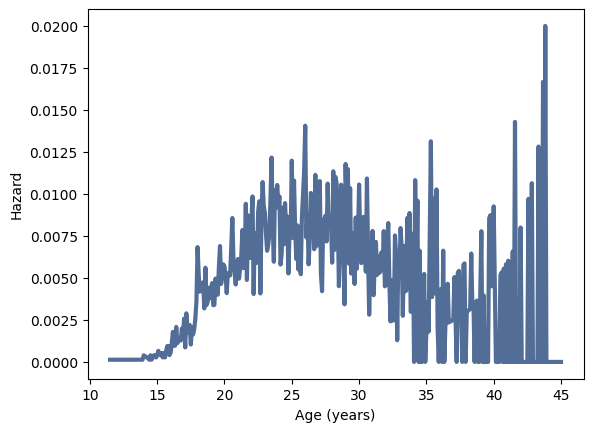

In [12]:
# Plot the hazard function
thinkplot.Plot(hf)
thinkplot.Config(xlabel="Age (years)", ylabel="Hazard")

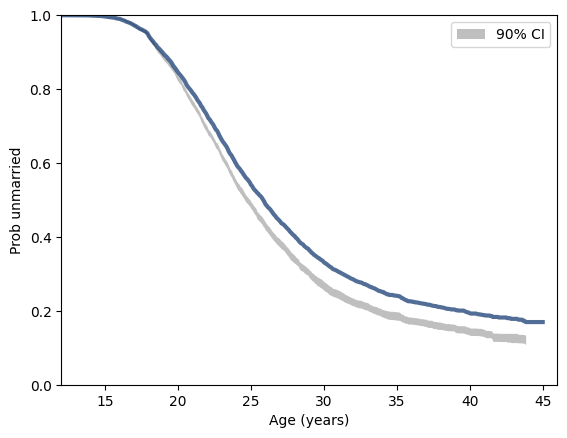

In [13]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

# Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.
def EstimateMarriageSurvival(resp):
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age
    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()
    return hf, sf

def ResampleSurvival(resp, iters=101):
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)
    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1 / 12.0)
    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))
    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color="gray", label="90% CI")

ResampleSurvival(resp6)
thinkplot.Config(xlabel="Age (years)", ylabel="Prob unmarried", xlim=[12, 46], ylim=[0, 1], loc="upper right")

In [13]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz")

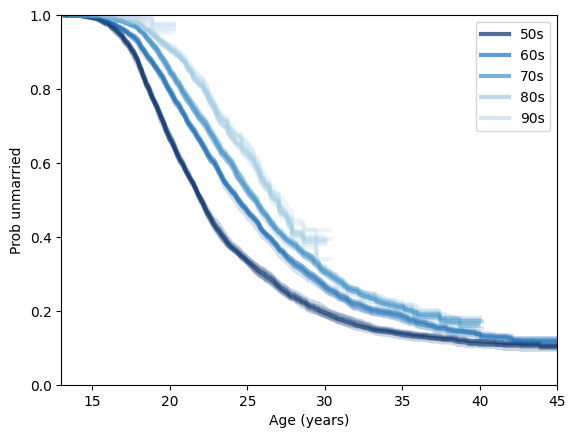

In [16]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")


# Divide the respondents into groups by decade of birth, and possibly by age at first marriage.
resp5 = survival.ReadFemResp1995()
resp7 = survival.ReadFemResp2010()
resps = [resp5, resp6, resp7]

def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if omit:
            groups = [(name, group) for name, group in groups if name not in omit]
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)
        if predict_flag:
            survival.PlotPredictionsByDecade(groups, alpha=0.1)
            survival.EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            survival.EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

PlotResampledByDecade(resps)
thinkplot.Config(xlabel="Age (years)", ylabel="Prob unmarried", xlim=[13, 45], ylim=[0, 1])